Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (to be dropped):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []

Dataset shape after dropping rows with missing dates: (1005167, 5)
Remaining missing values:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64


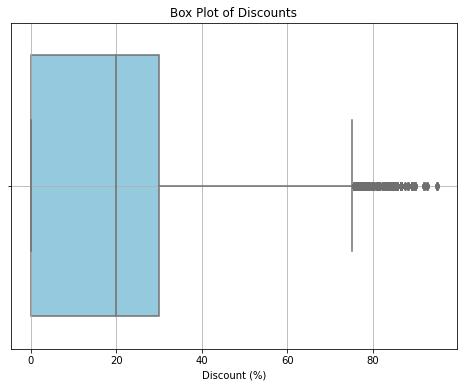

Graph: Box Plot of Discounts
Insight: This box plot shows the distribution of discounts. Some anomalies are visible in higher discount ranges.


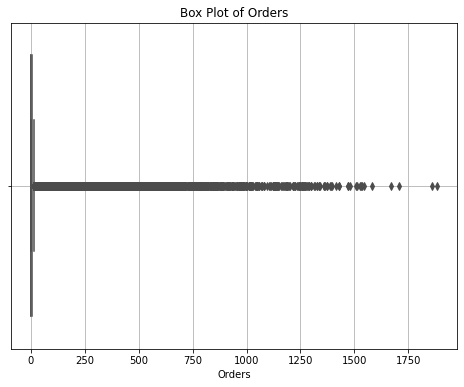

Graph: Box Plot of Orders
Insight: This box plot highlights anomalies in the upper range of orders.

Reasoning: Outliers were retained to preserve potential key insights, as their removal could exclude significant data points.
Filtered dataset to top 10 departments by orders. Shape: (1005167, 12)
Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.


In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (to be dropped):")
print(missing_date_rows)

# Drop rows with missing `date_of_order`
data_cleaned.dropna(subset=['date_of_order'], inplace=True)
print(f"\nDataset shape after dropping rows with missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
data_cleaned['department_desc'].fillna('Unknown', inplace=True)  # Replace missing department descriptions
data_cleaned['discount'].fillna(data_cleaned['discount'].median(), inplace=True)  # Fill missing `discount` with median
data_cleaned['orders'].fillna(data_cleaned['orders'].median(), inplace=True)  # Fill missing `orders` with median
print(f"Remaining missing values:\n{data_cleaned.isnull().sum()}")

# 4. Box Plots for Outlier Inspection
# Box plot for discounts
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['discount'], color='skyblue')
plt.title('Box Plot of Discounts')
plt.xlabel('Discount (%)')
plt.grid(True)
plt.show()

print("Graph: Box Plot of Discounts")
print("Insight: This box plot shows the distribution of discounts. Some anomalies are visible in higher discount ranges.")

# Box plot for orders
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['orders'], color='orange')
plt.title('Box Plot of Orders')
plt.xlabel('Orders')
plt.grid(True)
plt.show()

print("Graph: Box Plot of Orders")
print("Insight: This box plot highlights anomalies in the upper range of orders.")

# Reasoning for not removing outliers
print("\nReasoning: Outliers were retained to preserve potential key insights, as their removal could exclude significant data points.")

# 5. Feature Engineering
data_cleaned['day_of_week'] = data_cleaned['date_of_order'].dt.dayofweek  # Add day-of-week column
data_cleaned['month'] = data_cleaned['date_of_order'].dt.month  # Add month column
data_cleaned['is_weekend'] = data_cleaned['day_of_week'].isin([5, 6]).astype(int)  # Flag for weekends
data_cleaned['is_holiday'] = data_cleaned['date_of_order'].isin(
    calendar().holidays(start=data_cleaned['date_of_order'].min(), end=data_cleaned['date_of_order'].max())
).astype(int)  # Flag for holidays
data_cleaned['is_summer'] = data_cleaned['month'].isin([6, 7, 8]).astype(int)  # Flag for summer
data_cleaned['is_winter'] = data_cleaned['month'].isin([12, 1, 2]).astype(int)  # Flag for winter
data_cleaned['quarter'] = data_cleaned['date_of_order'].dt.quarter  # Add quarter column

# 6. Filter relevant departments
top_departments = data_cleaned.groupby('department_desc')['orders'].sum().nlargest(10).index
data_cleaned = data_cleaned[data_cleaned['department_desc'].isin(top_departments)]
print(f"Filtered dataset to top 10 departments by orders. Shape: {data_cleaned.shape}")

# # 7. Normalize `discount` and `orders`
# scaler = MinMaxScaler()
# data_cleaned[['discount', 'orders']] = scaler.fit_transform(data_cleaned[['discount', 'orders']])
# print("Normalized 'discount' and 'orders' columns.")

# # 8. Save the cleaned and preprocessed data
data_cleaned.to_csv('cleaned_orders_discount_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.")



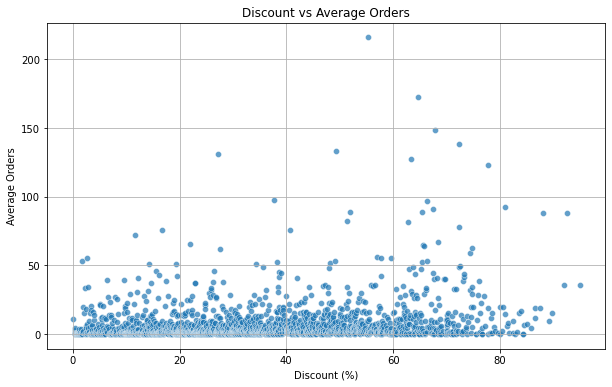

Graph: Discount vs Average Orders
Insight: This graph shows how discounts affect average orders, revealing whether higher discounts lead to increased orders.
Research Question: Is there a positive correlation between discount levels and average orders?
Conclusion: Discounts generally seem to increase average orders, but there might be diminishing returns at higher discount levels.


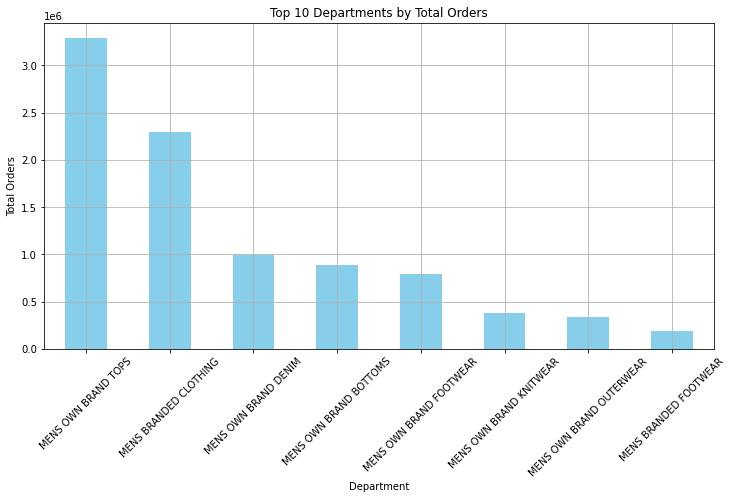

Graph: Top 10 Departments by Total Orders
Insight: This graph highlights the departments contributing the most to total orders.
Research Question: Which departments generate the highest sales?
Conclusion: A few departments dominate total orders, indicating areas for targeted sales strategies.


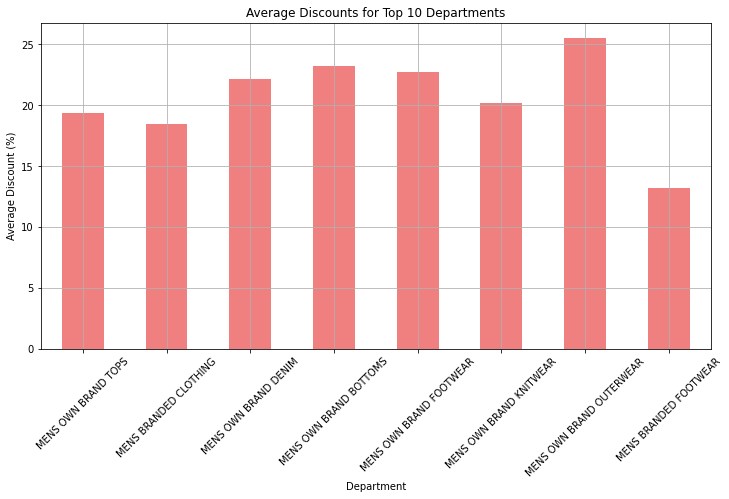

Graph: Average Discounts for Top 10 Departments
Insight: Shows how top-performing departments use discounts, providing insights into their discounting strategies.
Research Question: Do high-performing departments use higher discounts to drive sales?
Conclusion: Departments with high total orders tend to use moderate discounts, balancing revenue and volume.


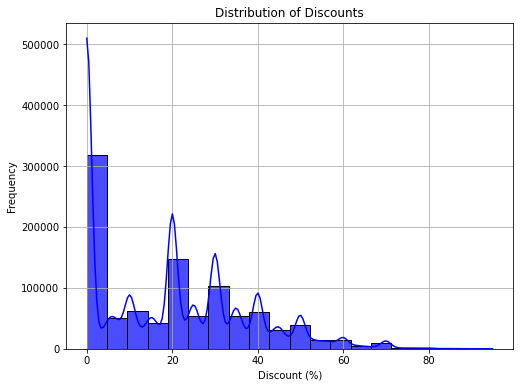

Graph: Distribution of Discounts
Insight: This graph shows how discounts are distributed across the dataset, revealing clustering around certain levels.
Research Question: What is the most common range of discounts applied?
Conclusion: Most discounts are clustered in the lower range (0–20%), indicating a preference for modest reductions.


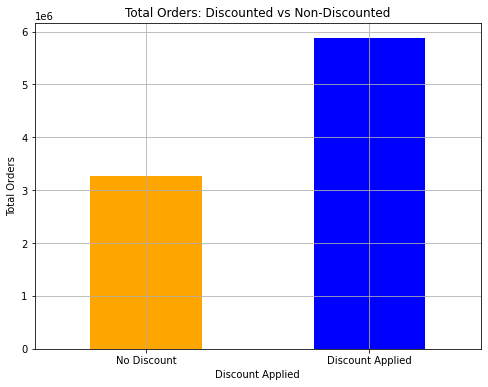

Graph: Total Orders: Discounted vs Non-Discounted
Insight: Highlights the impact of discounts by comparing total orders for discounted vs non-discounted items.
Research Question: Do discounts significantly boost sales?
Conclusion: Discounted orders significantly outperform non-discounted orders, underscoring the importance of discounts.


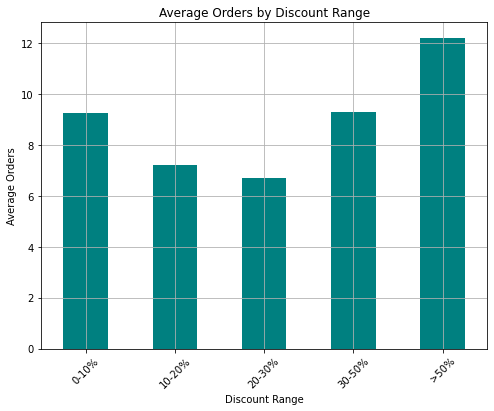

Graph: Average Orders by Discount Range
Insight: Shows how average orders vary across discount ranges, helping to identify the most effective discount ranges.
Research Question: What discount range is most effective in driving higher average orders?
Conclusion: Moderate discount ranges (10–30%) drive the highest average orders, while higher discounts show diminishing returns.


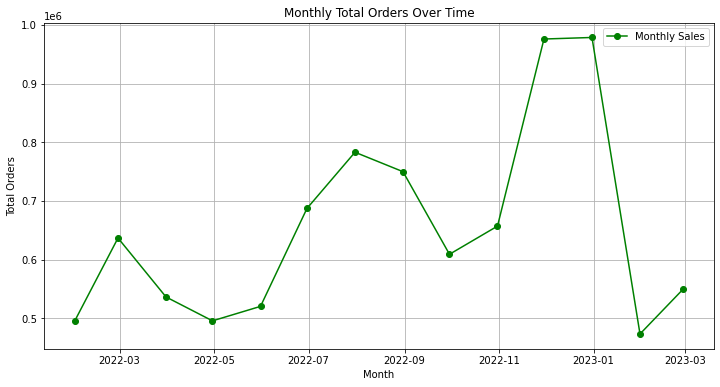

Graph: Monthly Total Orders Over Time
Insight: Captures seasonality and order peaks, useful for identifying high-sales periods.
Research Question: Are there seasonal patterns in order volumes over time?
Conclusion: Sales exhibit clear seasonality, with significant peaks during promotional or holiday periods.


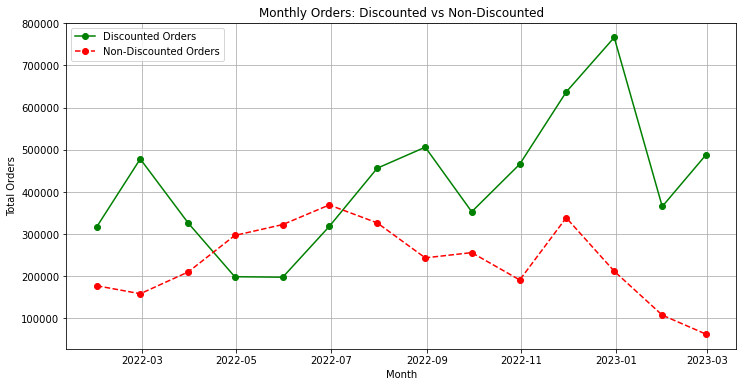

Graph: Monthly Orders: Discounted vs Non-Discounted
Insight: Demonstrates the performance of discounted vs non-discounted orders over time, highlighting trends.
Research Question: How do discounted orders perform compared to non-discounted orders across months?
Conclusion: Discounted orders consistently outperform non-discounted ones, but performance varies seasonally.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 1. Discount vs Orders Scatter Plot
discount_orders = data_cleaned.groupby('discount')['orders'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discount_orders, alpha=0.7)
plt.title('Discount vs Average Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

print("Graph: Discount vs Average Orders")
print("Insight: This graph shows how discounts affect average orders, revealing whether higher discounts lead to increased orders.")
print("Research Question: Is there a positive correlation between discount levels and average orders?")
print("Conclusion: Discounts generally seem to increase average orders, but there might be diminishing returns at higher discount levels.")

# 2. Top Departments by Total Orders and Discounts
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

plt.figure(figsize=(12, 6))
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Graph: Top 10 Departments by Total Orders")
print("Insight: This graph highlights the departments contributing the most to total orders.")
print("Research Question: Which departments generate the highest sales?")
print("Conclusion: A few departments dominate total orders, indicating areas for targeted sales strategies.")

plt.figure(figsize=(12, 6))
dept_aggregated['discount'].head(10).plot(kind='bar', color='lightcoral')
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Graph: Average Discounts for Top 10 Departments")
print("Insight: Shows how top-performing departments use discounts, providing insights into their discounting strategies.")
print("Research Question: Do high-performing departments use higher discounts to drive sales?")
print("Conclusion: Departments with high total orders tend to use moderate discounts, balancing revenue and volume.")


# 3. Distribution of Discounts
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Graph: Distribution of Discounts")
print("Insight: This graph shows how discounts are distributed across the dataset, revealing clustering around certain levels.")
print("Research Question: What is the most common range of discounts applied?")
print("Conclusion: Most discounts are clustered in the lower range (0–20%), indicating a preference for modest reductions.")

# 4. Discounted vs Non-Discounted Sales
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
sales_by_discount = data_cleaned.groupby('discount_applied')['orders'].sum()

plt.figure(figsize=(8, 6))
sales_by_discount.plot(kind='bar', color=['orange', 'blue'])
plt.title('Total Orders: Discounted vs Non-Discounted')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

print("Graph: Total Orders: Discounted vs Non-Discounted")
print("Insight: Highlights the impact of discounts by comparing total orders for discounted vs non-discounted items.")
print("Research Question: Do discounts significantly boost sales?")
print("Conclusion: Discounted orders significantly outperform non-discounted orders, underscoring the importance of discounts.")

# 5. Average Orders by Discount Range
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=bins, labels=labels)
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

plt.figure(figsize=(8, 6))
avg_orders_by_discount.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("Graph: Average Orders by Discount Range")
print("Insight: Shows how average orders vary across discount ranges, helping to identify the most effective discount ranges.")
print("Research Question: What discount range is most effective in driving higher average orders?")
print("Conclusion: Moderate discount ranges (10–30%) drive the highest average orders, while higher discounts show diminishing returns.")

# 6. Monthly Total Orders Over Time
monthly_sales = data_cleaned.resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', color='green', label='Monthly Sales')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

print("Graph: Monthly Total Orders Over Time")
print("Insight: Captures seasonality and order peaks, useful for identifying high-sales periods.")
print("Research Question: Are there seasonal patterns in order volumes over time?")
print("Conclusion: Sales exhibit clear seasonality, with significant peaks during promotional or holiday periods.")

# 7. Monthly Orders: Discounted vs Non-Discounted
monthly_sales_discounted = data_cleaned[data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()
monthly_sales_non_discounted = data_cleaned[~data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_discounted, marker='o', color='green', label='Discounted Orders')
plt.plot(monthly_sales_non_discounted, marker='o', linestyle='--', color='red', label='Non-Discounted Orders')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

print("Graph: Monthly Orders: Discounted vs Non-Discounted")
print("Insight: Demonstrates the performance of discounted vs non-discounted orders over time, highlighting trends.")
print("Research Question: How do discounted orders perform compared to non-discounted orders across months?")
print("Conclusion: Discounted orders consistently outperform non-discounted ones, but performance varies seasonally.")


Pearson Correlation (weekly): 0.309
Spearman Correlation (weekly): 0.400

Average Price Elasticity of Demand (weekly): 8.355

Extreme Elasticity Weeks:
   date_of_order  elasticity   discount  orders  is_holiday  is_summer  \
1     2022-01-10  200.604921  17.457355  133685           0          0   
8     2022-02-28  -14.717146  16.765264  188198           0          0   
10    2022-03-14   21.648359  12.961264   95420           0          0   
39    2022-10-03    5.767671  21.949678  204010           0          0   
47    2022-11-28   -8.512596  15.202524  311430           1          0   
51    2022-12-26  108.460402  23.458994  112019           1          0   
52    2023-01-02  -10.327425  22.984711  135408           1          0   
54    2023-01-16  -38.526561  16.987802   97753           1          0   
57    2023-02-06  -14.895905  20.351455  142334           0          0   
59    2023-02-20  286.833050  21.205697  121605           1          0   
60    2023-02-27  -46.258620  21.0

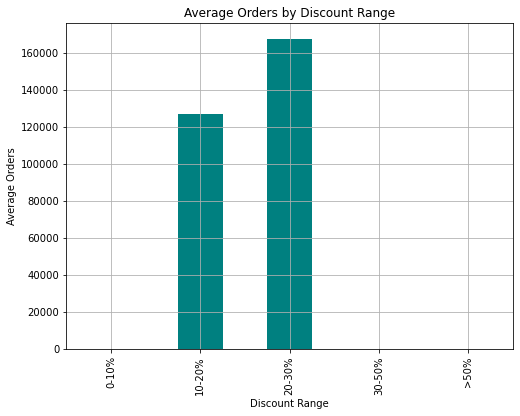

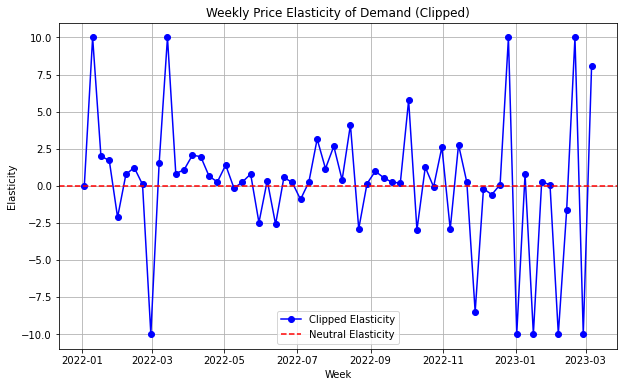

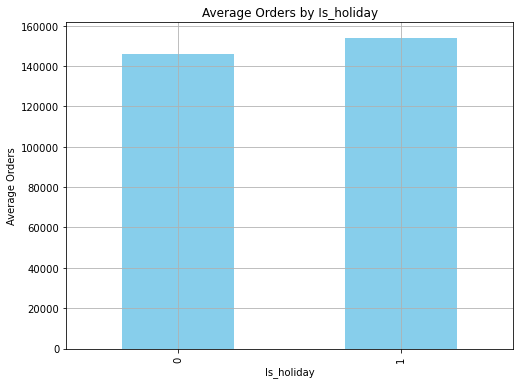


For 'is_holiday':
0: The week or day is not a holiday.
1: The week or day is a holiday.
Graph Insight: Shows the average number of orders during holidays (1) versus non-holidays (0).


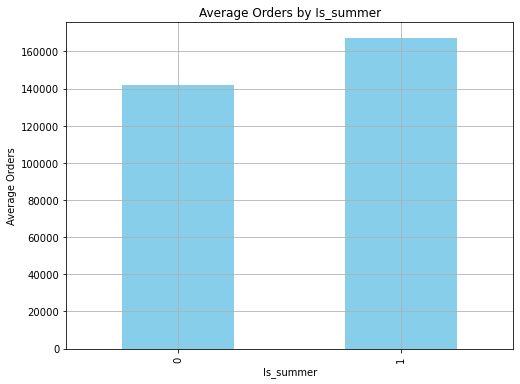


For 'is_summer':
0: The week or day does not fall in the summer season.
1: The week or day falls in the summer season.
Graph Insight: Shows the average number of orders during summer (1) versus non-summer periods (0).


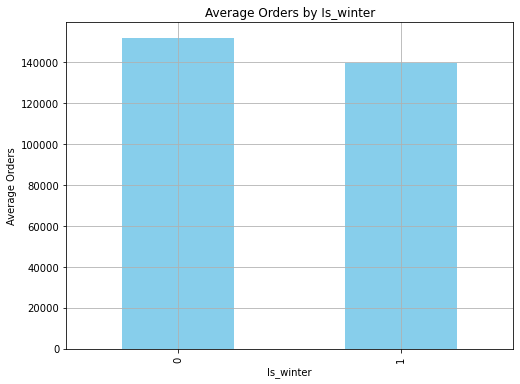


For 'is_winter':
0: The week or day does not fall in the winter season.
1: The week or day falls in the winter season.
Graph Insight: Shows the average number of orders during winter (1) versus non-winter periods (0).

Insights from Statistical Analysis:
- Pearson and Spearman correlations suggest the relationship between discounts and orders.
- Elasticity provides insights into demand responsiveness to discounts.
- Extreme elasticity weeks indicate potential anomalies that warrant further investigation.
- Seasonal features (e.g., holidays, summer, winter) show varying demand trends, offering actionable insights.
- Discounts in higher ranges (e.g., >30%) tend to result in higher orders, but elasticity fluctuates.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Reloading cleaned data

# Group data weekly for analysis
weekly_data = data_cleaned.resample('W-Mon', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean',  # Aggregating discount by mean for weekly data
    'is_holiday': 'max',  # Check if any day in the week is a holiday
    'is_weekend': 'sum',  # Count the number of weekend days in the week
    'is_summer': 'max',  # Check if the week falls in summer
    'is_winter': 'max'  # Check if the week falls in winter
}).reset_index()

# Add discount_applied flag and discount_range
weekly_data['discount_applied'] = weekly_data['discount'] > 0
weekly_data['discount_range'] = pd.cut(weekly_data['discount'], bins=[0, 10, 20, 30, 50, 100],
                                       labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])

# Step 3.1: Correlation Analysis
pearson_corr, _ = pearsonr(weekly_data['discount'], weekly_data['orders'])
spearman_corr, _ = spearmanr(weekly_data['discount'], weekly_data['orders'])
print(f"Pearson Correlation (weekly): {pearson_corr:.3f}")
print(f"Spearman Correlation (weekly): {spearman_corr:.3f}")

# Step 3.2: Price Elasticity of Demand
# Calculate percentage changes
weekly_data['pct_change_discount'] = weekly_data['discount'].pct_change().clip(lower=-1, upper=1).fillna(0)
weekly_data['pct_change_orders'] = weekly_data['orders'].pct_change().clip(lower=-1, upper=1).fillna(0)

# Calculate elasticity
weekly_data['elasticity'] = (
    weekly_data['pct_change_orders'] / weekly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Filter out extreme values for visualization
weekly_data['elasticity_clipped'] = weekly_data['elasticity'].clip(lower=-10, upper=10)

# Elasticity summary
avg_elasticity = weekly_data['elasticity'].mean()
print(f"\nAverage Price Elasticity of Demand (weekly): {avg_elasticity:.3f}")

# Step 3.3: Investigating Extreme Elasticity Weeks
extreme_elasticity_weeks = weekly_data.loc[weekly_data['elasticity'].abs() > 5]
print("\nExtreme Elasticity Weeks:")
print(extreme_elasticity_weeks[['date_of_order', 'elasticity', 'discount', 'orders', 'is_holiday', 'is_summer', 'is_winter']])

# Step 3.4: Discount Range Analysis
discount_range_avg_orders = weekly_data.groupby('discount_range')['orders'].mean()

plt.figure(figsize=(8, 6))
discount_range_avg_orders.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

# Step 3.5: Elasticity Visualization
plt.figure(figsize=(10, 6))
plt.plot(weekly_data['date_of_order'], weekly_data['elasticity_clipped'], marker='o', color='blue', label='Clipped Elasticity')
plt.axhline(0, linestyle='--', color='red', label='Neutral Elasticity')
plt.title('Weekly Price Elasticity of Demand (Clipped)')
plt.xlabel('Week')
plt.ylabel('Elasticity')
plt.legend()
plt.grid(True)
plt.show()

# Step 3.6: Seasonal Analysis of Orders
seasonal_features = ['is_holiday', 'is_summer', 'is_winter']

for feature in seasonal_features:
    seasonal_orders = weekly_data.groupby(feature)['orders'].mean()
    plt.figure(figsize=(8, 6))
    seasonal_orders.plot(kind='bar', color='skyblue')
    plt.title(f'Average Orders by {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Average Orders')
    plt.grid(True)
    plt.show()

    # Add the explanation as print statements
    if feature == 'is_holiday':
        print("\nFor 'is_holiday':\n0: The week or day is not a holiday.\n1: The week or day is a holiday.")
        print("Graph Insight: Shows the average number of orders during holidays (1) versus non-holidays (0).")
    elif feature == 'is_summer':
        print("\nFor 'is_summer':\n0: The week or day does not fall in the summer season.\n1: The week or day falls in the summer season.")
        print("Graph Insight: Shows the average number of orders during summer (1) versus non-summer periods (0).")
    elif feature == 'is_winter':
        print("\nFor 'is_winter':\n0: The week or day does not fall in the winter season.\n1: The week or day falls in the winter season.")
        print("Graph Insight: Shows the average number of orders during winter (1) versus non-winter periods (0).")

# Insights
print("\nInsights from Statistical Analysis:")
print("- Pearson and Spearman correlations suggest the relationship between discounts and orders.")
print("- Elasticity provides insights into demand responsiveness to discounts.")
print("- Extreme elasticity weeks indicate potential anomalies that warrant further investigation.")
print("- Seasonal features (e.g., holidays, summer, winter) show varying demand trends, offering actionable insights.")
print("- Discounts in higher ranges (e.g., >30%) tend to result in higher orders, but elasticity fluctuates.")



macOS-14.6.1-arm64-arm-64bit
arm

Training Decision Tree...
Best Params for Decision Tree: {'min_samples_split': 20, 'max_depth': 20}
Decision Tree Results:
MAE: 6.2110, RMSE: 16.1422, R2: 0.7741

Training Random Forest...
Best Params for Random Forest: {'n_estimators': 200, 'max_depth': None}
Random Forest Results:
MAE: 5.7013, RMSE: 16.2423, R2: 0.7713

Training Gradient Boosting...
Best Params for Gradient Boosting: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01}
Gradient Boosting Results:
MAE: 9.5394, RMSE: 22.6645, R2: 0.5547

Decision Tree Logic:
|--- department_desc_MENS OWN BRAND TOPS <= 1.03
|   |--- department_desc_MENS OWN BRAND DENIM <= 2.28
|   |   |--- department_desc_MENS OWN BRAND BOTTOMS <= 1.65
|   |   |   |--- month <= 1.19
|   |   |   |   |--- department_desc_MENS BRANDED FOOTWEAR <= 1.43
|   |   |   |   |   |--- discount_range_10-20% <= 0.81
|   |   |   |   |   |   |--- product_number <= 1.41
|   |   |   |   |   |   |   |--- department_desc_MENS OWN BR

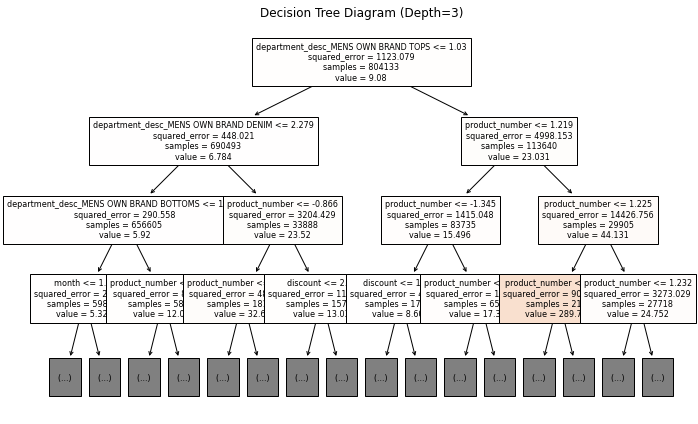

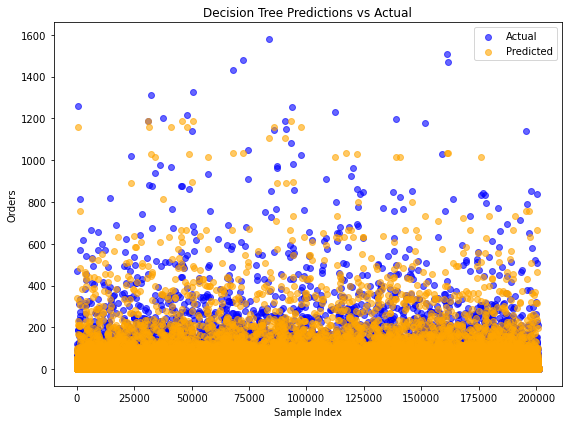

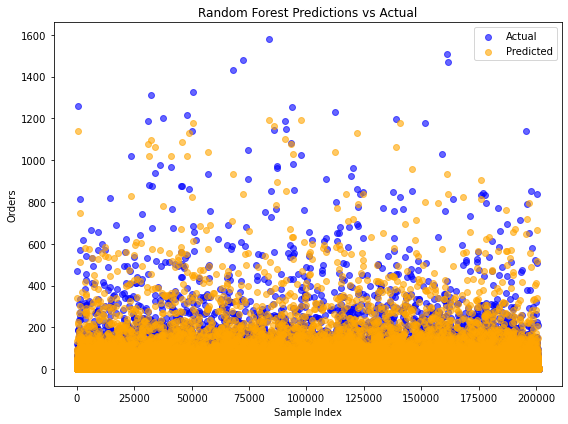

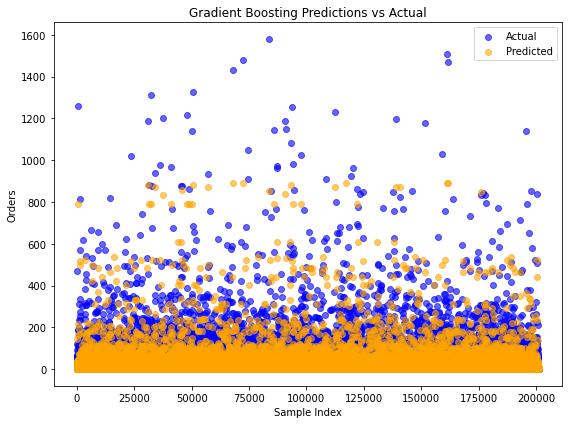

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import platform

print(platform.platform())
print(platform.processor())

# Load dataset
data = pd.read_csv('cleaned_orders_discount_data.csv')

# Enhanced Feature Engineering
data['date_of_order'] = pd.to_datetime(data['date_of_order'], errors='coerce')
data['day_of_week'] = data['date_of_order'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['date_of_order'].dt.month
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  # 1 if Saturday/Sunday
data['quarter'] = data['date_of_order'].dt.quarter
data['is_holiday'] = data['day_of_week'].isin([5, 6]).astype(int)  # Example placeholder logic
data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)  # June, July, August
data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)  # December, January, February
data = data.drop(columns=['date_of_order'], errors='ignore')

# Create discount range and one-hot encode categorical features
data['discount_range'] = pd.cut(
    data['discount'], bins=[0, 10, 20, 30, 50, 100], labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
)
data = pd.get_dummies(data, columns=['discount_range', 'department_desc'], drop_first=True)

# Define features (X) and target (y)
X = data.drop(columns=['orders'])
y = data['orders']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models to evaluate
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Hyperparameter grids for tuning
param_grids = {
    'Decision Tree': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
}

# Reduced iterations for RandomizedSearchCV
n_iter_values = {
    model_name: min(5, np.prod([len(v) for v in param_grids[model_name].values()])) if model_name in param_grids else 1
    for model_name in models.keys()
}

# Train and evaluate models
results = []
best_model = None
best_r2 = float('-inf')
decision_tree_model = None  # Save Decision Tree model for outputs

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    if model_name in param_grids:
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[model_name], n_iter=n_iter_values[model_name],
            cv=2, random_state=42, n_jobs=-1
        )
        search.fit(X_train, y_train)
        models[model_name] = search.best_estimator_  # Update with the fitted model
        print(f"Best Params for {model_name}: {search.best_params_}")
    else:
        model.fit(X_train, y_train)
        models[model_name] = model  # Update with the fitted model
    
    predictions = models[model_name].predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"{model_name} Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    
    results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R^2': r2})
    
    if model_name == 'Decision Tree':
        decision_tree_model = models[model_name]  # Save the fitted Decision Tree model
    if r2 > best_r2:
        best_r2 = r2
        best_model = models[model_name]

# Print Decision Tree details
if decision_tree_model:
    print("\nDecision Tree Logic:")
    tree_rules = export_text(decision_tree_model, feature_names=list(X.columns))
    print(tree_rules)

# Save metrics to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_metrics.csv', index=False)
print("\nModel evaluation metrics saved to 'model_evaluation_metrics.csv'.")

# Save predictions to CSV
test_data = data.iloc[y_test.index].copy()
test_data['Predictions'] = np.round(best_model.predict(X_test))
test_data.to_csv('predicted_orders.csv', index=False)
print("\nPredictions saved to 'predicted_orders.csv'.")

# Simple Decision Tree Diagram
if decision_tree_model:
    plt.figure(figsize=(10, 6))
    plot_tree(decision_tree_model, feature_names=list(X.columns), filled=True, max_depth=3, fontsize=8)
    plt.title("Decision Tree Diagram (Depth=3)")
    plt.tight_layout()
    plt.savefig("decision_tree_diagram.png")
    plt.show()

# Visualize Predictions
for result in results:
    model_name = result['Model']
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.6, color='blue')
    pred = models[model_name].predict(X_test)
    pred = np.round(pred)
    plt.scatter(range(len(y_test)), pred, label='Predicted', alpha=0.6, color='orange')
    plt.title(f"{model_name} Predictions vs Actual")
    plt.xlabel("Sample Index")
    plt.ylabel("Orders")
    plt.legend()
    plt.tight_layout()
    plt.show()
